In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def normalize_vector(vector, eps=1e-8):
    vector = vector.to(dtype=torch.float32) 
    norm = torch.norm(vector, p=2)
    if norm < eps:
        return torch.zeros_like(vector)  # Avoid division by zero
    vector = vector / norm
    return vector

def normalize_map(map):
    min = map.min()
    max = map.max()
    if max == min:
        return torch.zeros_like(map) # Avoid division by zero
    map = (map - min) / (max - min)
    return map

def generate_grid_coordinates(H, W):
    x_coords, y_coords = torch.meshgrid(torch.arange(W, dtype=torch.float32),
                                        torch.arange(H, dtype=torch.float32), 
                                        indexing="xy")
    coords = torch.cat((x_coords.unsqueeze(-1), y_coords.unsqueeze(-1)), dim=-1)
    coords = coords + 0.5 # Shift for 0-indexing
    return coords

def get_grid_center(H, W):
    center = torch.tensor([W / 2, H / 2], dtype=torch.float32)
    return center

def displacement_from_point(positions, point, scaled=False):
    displacement = positions - point 
    if scaled:
        scale = torch.amax(positions, dim=(0, 1))
        displacement = displacement / (scale + 1e-6)
    return displacement

def manhattan_distance_to_point(positions, point, scaled=False):
    displacement = displacement_from_point(positions, point, scaled)
    distances = torch.sum(torch.abs(displacement), dim=-1)  # Scaled L1 norm
    return distances

def distance_to_line(positions, normal, displacement, signed=False):
    normal = normalize_vector(normal)                    
    distances = torch.sum(positions * normal, dim=-1) - displacement
    if not signed:
        distances = torch.abs(distances)
    return distances

def gaussian_weighting(distances, sigma=1):
    distances = torch.exp(- (distances ** 2) / (2 * sigma))
    return distances

def visualise_attn(attn_map, cmap='Blues'):
    plt.figure(figsize=(3, 4))
    plt.imshow(attn_map, cmap=cmap)
    plt.axis("off")
    plt.show()

In [ ]:
def rot_lines(H, W):
    positions = generate_grid_coordinates(H, W)
    horizontal_normal = torch.tensor([0, 1])
    vertical_normal = torch.tensor([1, 0])

    H1_distances = distance_to_line(positions, horizontal_normal, H / 3)
    H2_distances = distance_to_line(positions, horizontal_normal, 2 * H / 3)
    H_distances = torch.min(H1_distances, H2_distances)

    V1_distances = distance_to_line(positions, vertical_normal, W / 3)
    V2_distances = distance_to_line(positions, vertical_normal, 2 * W / 3)
    V_distances = torch.min(V1_distances, V2_distances)

    distances = H_distances + V_distances
    distances = gaussian_weighting(distances)
    print("min =", distances.min().item(), "max =", distances.max().item(), "mean =", distances.mean().item())
    visualise_attn(distances)

    return distances

def rot_points(H, W):
    positions = generate_grid_coordinates(H, W)
    dist_1 = manhattan_distance_to_point(positions, torch.tensor([W / 3, H / 3]))
    dist_2 = manhattan_distance_to_point(positions, torch.tensor([2 * W / 3, H / 3]))
    dist_3 = manhattan_distance_to_point(positions, torch.tensor([W / 3, 2 * H / 3]))
    dist_4 = manhattan_distance_to_point(positions, torch.tensor([2 * W / 3, 2 * H / 3]))

    distances = torch.min(torch.stack([dist_1, dist_2, dist_3, dist_4], dim=0), dim=0).values
    distances = gaussian_weighting(distances)
    print("min =", distances.min().item(), "max =", distances.max().item(), "mean =", distances.mean().item())
    visualise_attn(distances)

    return distances

def symmetry_mse(attn_map, sigma=1):
    H, W = attn_map.shape
    attn_map = normalize_map(attn_map)
    mirror = torch.flip(attn_map, dims=[1])  # Flip horizontal
    score = torch.mean((attn_map - mirror)**2)
    return score

def symmetry_gaussian(attn_map):
    attn_map = normalize_map(attn_map)
    mirror = torch.flip(attn_map, dims=[1])  # Flip horizontal
    weight = gaussian_weighting((attn_map - mirror)**2, torch.var(attn_map**2)/10)
    print("min =", weight.min().item(), "max =", weight.max().item(), "mean =", weight.mean().item())
    visualise_attn(weight, cmap='hot')
    score = torch.mean(weight)
    return score

def moment_of_balance(attn_map):
    H, W = attn_map.shape 
    positions = generate_grid_coordinates(H, W)
    attn_mass = torch.sum(attn_map) + 1e-6 # Avoid division by zero
    moments = torch.sum(attn_map.unsqueeze(-1) * positions, dim=(0,1)) 
    centroid = moments / attn_mass
    centroid = centroid * (torch.abs(centroid) > 1e-7)  # Set small values to zero
    image_center = get_grid_center(H, W)
    score = manhattan_distance_to_point(centroid, image_center)
    
    return score, centroid

def second_moment(attn_map, reference_point):
    H, W = attn_map.shape
    positions = generate_grid_coordinates(H, W)  # Shape: (H, W, 2)
    
    # Compute squared Euclidean distance from reference point
    distances_sq = torch.sum((positions - reference_point) ** 2, dim=-1)
    
    # Weighted sum of squared distances
    attn_mass = torch.sum(attn_map) + 1e-6  # Avoid division by zero
    second_moment = torch.sum(attn_map * distances_sq) / attn_mass
    
    return second_moment

def skewness(attn_map, reference_point):
    H, W = attn_map.shape
    positions = generate_grid_coordinates(H, W)  # Shape: (H, W, 2)
    
    # Compute mean-centered coordinates
    centered_positions = positions - reference_point  # Shape: (H, W, 2)
    
    # Compute standard deviation for x and y
    attn_mass = torch.sum(attn_map) + 1e-6
    std_dev = torch.sqrt(torch.sum(attn_map.unsqueeze(-1) * centered_positions**2, dim=(0,1)) / attn_mass)
    
    # Compute skewness (third moment)
    skewness = torch.sum(attn_map.unsqueeze(-1) * (centered_positions / (std_dev + 1e-6))**3, dim=(0,1)) / attn_mass
    
    return skewness

# APPROACHES TO CONSIDER
# Moments (centroid, variance, skewness) → Statistical balance.
# Fourier transform → Spatial balance, symmetry, rule-of-thirds.
# Divergence & curl → Vector field balance, spread, and rotational asymmetry.
# PCA → Dominant attention directions and feature reduction.

min = 8.323913474862993e-16 max = 0.8007375001907349 mean = 0.08024037629365921


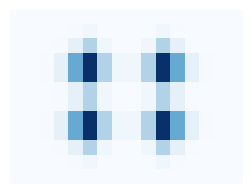

min = 8.323913474862993e-16 max = 0.8007375001907349 mean = 0.08024037629365921


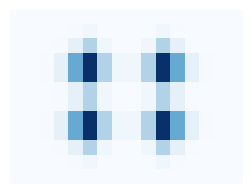

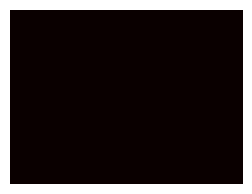

In [43]:
lines = rot_lines(12, 16)
points = rot_points(12, 16)
visualise_attn(torch.abs(lines - points), "hot")

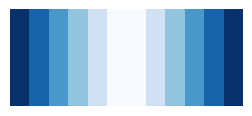

(tensor(0.), tensor([6.0000, 2.5000]))

In [34]:
H, W = 5, 12
# attn_map = torch.randn(H, W)
normal_vector = torch.tensor([1, 0])
displacement = W / 2
positions = generate_grid_coordinates(H, W)
test_grid = distance_to_line(positions, normal_vector, displacement)
attn_map = normalize_map(test_grid)
visualise_attn(attn_map)
# balance_score(attn_map)
moment_of_balance(attn_map)

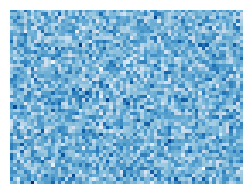

(tensor(43.7107), tensor([35.5517, 67.6589]))

In [35]:
attn_map = torch.randn(51, 68)
visualise_attn(attn_map)
normalize_map(attn_map)
symmetry_mse(attn_map)
moment_of_balance(attn_map)

In [ ]:
def generate_checkerboard(H=10, W=10):
    """Generate a symmetric checkerboard pattern as a torch tensor."""
    return torch.tensor(torch.arange(H) % 2).repeat(W, 1) ^ torch.tensor(torch.arange(H) % 2).repeat(W, 1).T

def generate_gradient(H=10, W=10):
    """Generate a linear gradient pattern as a torch tensor."""
    return torch.linspace(0, 1, W).repeat(H, 1)

def generate_radial_pattern(H=10, W=10):
    """Generate a radial gradient pattern as a torch tensor."""
    x, y = torch.meshgrid(torch.linspace(-1, 1, W), torch.linspace(-1, 1, H), indexing="xy")
    return torch.sqrt(x**2 + y**2)

def generate_spiral(H=10, W=10):
    """Generate a simple spiral pattern as a torch tensor."""
    x, y = torch.meshgrid(torch.linspace(-1, 1, W), torch.linspace(-1, 1, H), indexing="xy")
    return torch.sin(10 * torch.atan2(y, x))

def generate_noise(H=10, W=10):
    """Generate random noise pattern as a torch tensor."""
    return torch.rand(H, W)

def generate_conway_life(size=10, steps=5):
    """Generate a simple Conway's Game of Life pattern as a torch tensor."""
    grid = torch.randint(0, 2, (size, size))
    for _ in range(steps):
        new_grid = grid.clone()
        for i in range(1, size-1):
            for j in range(1, size-1):
                neighbors = torch.sum(grid[i-1:i+2, j-1:j+2]) - grid[i, j]
                if grid[i, j] == 1 and (neighbors < 2 or neighbors > 3):
                    new_grid[i, j] = 0
                elif grid[i, j] == 0 and neighbors == 3:
                    new_grid[i, j] = 1
        grid = new_grid
    return grid.float()

def generate_even_distribution(size=10):
    """Generate a pattern with evenly spaced salient pixels."""
    pattern = torch.zeros(size, size)
    pattern[::2, ::2] = 1  # Every second pixel is highlighted
    return pattern

/var/folders/18/h9m9_ktj0j95_gs7__ncptgc0000gn/T/ipykernel_63755/3079313098.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.arange(H) % 2).repeat(W, 1) ^ torch.tensor(torch.arange(H) % 2).repeat(W, 1).T


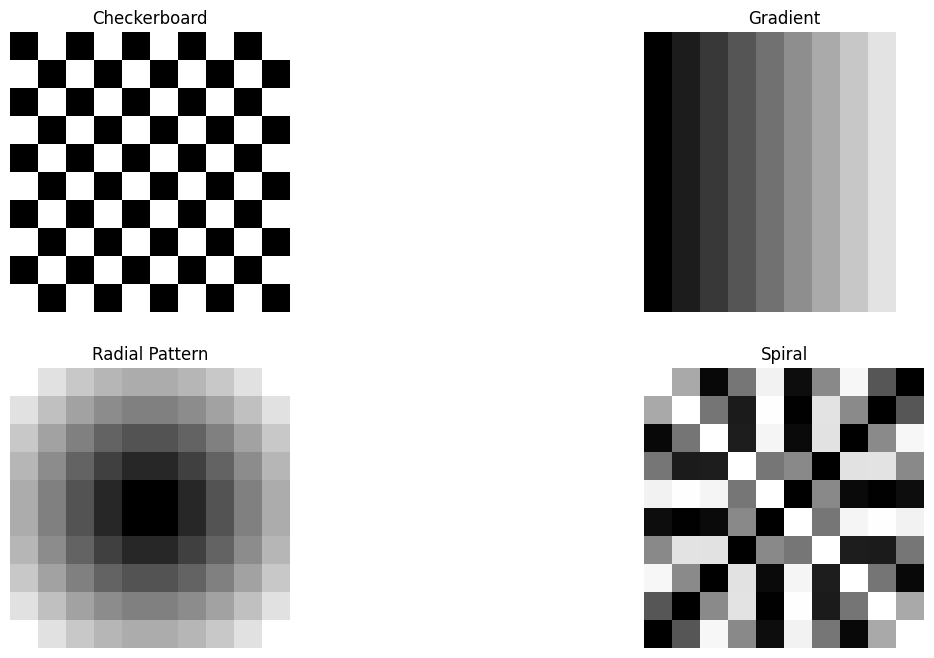

In [39]:
# Generate all patterns
patterns = {
    "Checkerboard": generate_checkerboard(),
    "Gradient": generate_gradient(),
    "Radial Pattern": generate_radial_pattern(),
    "Spiral": generate_spiral(),
    "Noise": generate_noise(),
}

# Display the patterns
fig, axes = plt.subplots(2, len(patterns) // 2, figsize=(15, 8))
axes = axes.flatten()
for ax, (title, pattern) in zip(axes, patterns.items()):
    ax.imshow(pattern, cmap='gray', interpolation='nearest')
    ax.set_title(title)
    ax.axis('off')